In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import warnings
import pandas as pd
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm

In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg') # Need to use in order to run on mac
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

#=============================================================================================

t_start = 1917 # start frame
t_end = 2130 # end frame

data = pd.read_csv('Smart-first_phase_NaN-zeros.csv') # only coordinate data
df = data.loc[t_start:t_end,'Shoulder_left_x':'Ankle_right_z']

# Find max and min values for animation ranges
df_minmax = pd.DataFrame(index=list('xyz'),columns=range(2))
for i in list('xyz'):
    c_max = df.filter(regex='_{}'.format(i)).max().max()
    c_min = df.filter(regex='_{}'.format(i)).min().min()
    df_minmax.ix[i] = np.array([c_min,c_max])

df_minmax = 1.3*df_minmax # increase by 30% to make animation look better

df.columns  = np.repeat(range(12),3) # store cols like this for simplicity
N_tag = df.shape[1]/3 # nr of tags used (all)

N_trajectories = N_tag

t = np.linspace(0,data.Time[t_end],df.shape[0]) # pseudo time-vector for first walking activity
x_t = np.zeros(shape=(N_tag,df.shape[0],3)) # empty animation array (3D)

for tag in range(12):
    # store data in numpy 3D array: (tag,time-stamp,xyz-coordinates)
    x_t[tag,:,:] = df[tag]

x_t = x_t[:, :, [0, 2, 1]]

# Set up figure & 3D axis for animation
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('on')

# choose a different color for each trajectory
colors = plt.cm.jet(np.linspace(0, 1, N_trajectories))
# set up trajectory lines
lines = sum([ax.plot([], [], [], '-', c=c) for c in colors], [])
# set up points
pts = sum([ax.plot([], [], [], 'o', c=c) for c in colors], [])
# set up lines which create the stick figures

stick_defines = [
    (0, 1),
    (1, 2),
    (3, 4),
    (4, 5),
    (6, 7),
    (7, 8),
    (9, 10),
    (10, 11)
]

stick_lines = [ax.plot([], [], [], 'k-')[0] for _ in stick_defines]

# prepare the axes limits
ax.set_xlim(df_minmax.ix['x'].values)
ax.set_ylim(df_minmax.ix['z'].values) # note usage of z coordinate
ax.set_zlim(df_minmax.ix['y'].values) # note usage of y coordinate

# set point-of-view: specified by (altitude degrees, azimuth degrees)
ax.view_init(30, 0)

# initialization function: plot the background of each frame
def init():
    for line, pt in zip(lines, pts):
        # trajectory lines
        line.set_data([], [])
        line.set_3d_properties([])
        # points
        pt.set_data([], [])
        pt.set_3d_properties([])
    return lines + pts + stick_lines

# animation function.  This will be called sequentially with the frame number
def animate(i):
    # we'll step two time-steps per frame.  This leads to nice results.
    i = (5 * i) % x_t.shape[1]

    for line, pt, xi in zip(lines, pts, x_t):
        x, y, z = xi[:i].T # note ordering of points to line up with true exogenous registration (x,z,y)
        pt.set_data(x[-1:], y[-1:])
        pt.set_3d_properties(z[-1:])

    for stick_line, (sp, ep) in zip(stick_lines, stick_defines):
        stick_line._verts3d = x_t[[sp,ep], i, :].T.tolist()

    ax.view_init(30, 0.3 * i)
    fig.canvas.draw()
    return lines + pts + stick_lines

# instantiate the animator.
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=500, interval=30, blit=True)

plt.show()

FileNotFoundError: [Errno 2] File b'Smart-first_phase_NaN-zeros.csv' does not exist: b'Smart-first_phase_NaN-zeros.csv'

In [2]:
import socceraction.spadl as spadl
import socceraction.spadl.statsbomb as statsbomb

In [11]:
# Use this if you only want to use the free public statsbomb data
free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
SBL = statsbomb.StatsBombLoader(root=free_open_data_remote,getter="remote")

In [12]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 "Women's World Cup"}

In [18]:
# Fifa world cup
selected_competitions = competitions[competitions.competition_name=="Premier League"]

selected_competitions

competition_id  season_id country_name competition_name  \
36               2         44      England   Premier League   

   competition_gender season_name               match_updated  \
36               male   2003/2004  2020-08-31T20:40:28.969635   

               match_available  
36  2020-08-31T20:40:28.969635

In [19]:
# Get matches from all selected competitions
matches = list(
    SBL.matches(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
)
matches = pd.concat(matches, sort=True).reset_index(drop=True)
matches[["home_team_name","away_team_name","match_date","home_score","away_score"]]

home_team_name           away_team_name  match_date  home_score  \
0                   Arsenal           Leicester City  2004-05-15           2   
1                   Arsenal        Manchester United  2004-03-28           1   
2                   Arsenal            Middlesbrough  2004-01-10           4   
3                   Arsenal        Charlton Athletic  2004-02-28           2   
4             Middlesbrough                  Arsenal  2003-08-24           0   
5              Leeds United                  Arsenal  2003-11-01           1   
6                 Liverpool                  Arsenal  2003-10-04           1   
7                   Arsenal                  Chelsea  2003-10-18           2   
8          Blackburn Rovers                  Arsenal  2004-03-13           0   
9               Aston Villa                  Arsenal  2004-01-18           0   
10                  Arsenal         Newcastle United  2003-09-26           3   
11                  Arsenal          Manchester City  2004-02-01           2   
12                  Arsenal          Birmingham City  2004-05-01           0   
13        Manchester United                  Arsenal  2003-09-21           0   
14                  Arsenal               Portsmouth  2003-09-13           1   
15          Manchester City                  Arsenal  2003-08-31           1   
16                  Chelsea                  Arsenal  2004-02-21           1   
17        Tottenham Hotspur                  Arsenal  2004-04-25           2   
18              Southampton                  Arsenal  2003-12-29           0   
19                  Arsenal                  Everton  2003-08-16           2   
20          Birmingham City                  Arsenal  2003-11-22           0   
21                  Arsenal                   Fulham  2003-11-30           0   
22                  Arsenal        Tottenham Hotspur  2003-11-08           2   
23                  Arsenal  Wolverhampton Wanderers  2003-12-26           3   
24                  Arsenal                Liverpool  2004-04-09           4   
25                  Arsenal         Bolton Wanderers  2004-03-20           2   
26                  Arsenal         Blackburn Rovers  2003-12-14           1   
27                  Arsenal             Leeds United  2004-04-16           5   
28         Bolton Wanderers                  Arsenal  2003-12-20           1   
29        Charlton Athletic                  Arsenal  2003-10-26           1   
30  Wolverhampton Wanderers                  Arsenal  2004-02-07           1   
31                   Fulham                  Arsenal  2004-05-09           0   
32         Newcastle United                  Arsenal  2004-04-11           0   

    away_score  
0            1  
1            1  
2            1  
3            1  
4            4  
5            4  
6            2  
7            1  
8            2  
9            2  
10           2  
11           1  
12           0  
13           0  
14           1  
15           2  
16           2  
17           2  
18           1  
19           1  
20           3  
21           0  
22           1  
23           0  
24           2  
25           1  
26           0  
27           0  
28           1  
29           1  
30           3  
31           1  
32           0

In [20]:
matches_verbose = tqdm.tqdm(list(matches.itertuples()),desc="Loading match data")
teams,players,player_games = [],[],[]
actions = {}
for match in matches_verbose:
    # load data
    teams.append(SBL.teams(match.match_id))
    players.append(SBL.players(match.match_id))
    events = SBL.events(match.match_id)
    
    # convert data
    player_games.append(statsbomb.extract_player_games(events))
    actions[match.match_id] = statsbomb.convert_to_actions(events,match.home_team_id)

games = matches.rename(columns={"match_id":"game_id"})
teams = pd.concat(teams).drop_duplicates("team_id").reset_index(drop=True)
players = pd.concat(players).drop_duplicates("player_id").reset_index(drop=True)
player_games = pd.concat(player_games).reset_index(drop=True)

Loading match data: 100%|██████████| 33/33 [00:48<00:00,  1.47s/it]


In [29]:
games

away_score away_team_gender away_team_group  away_team_id  \
0            1             male            None            22   
1            1             male            None            39   
2            1             male            None            47   
3            1             male            None            75   
4            4             male            None             1   
5            4             male            None             1   
6            2             male            None             1   
7            1             male            None            33   
8            2             male            None             1   
9            2             male            None             1   
10           2             male            None            37   
11           1             male            None            36   
12           0             male            None            54   
13           0             male            None             1   
14           1             male            None           105   
15           2             male            None             1   
16           2             male            None             1   
17           2             male            None             1   
18           1             male            None             1   
19           1             male            None            29   
20           3             male            None             1   
21           0             male            None            55   
22           1             male            None            38   
23           0             male            None            46   
24           2             male            None            24   
25           1             male            None           328   
26           0             male            None            98   
27           0             male            None           101   
28           1             male            None             1   
29           1             male            None             1   
30           3             male            None             1   
31           1             male            None             1   
32           0             male            None             1   

             away_team_name  competition_id competition_name country_name  \
0            Leicester City               2   Premier League      England   
1         Manchester United               2   Premier League      England   
2             Middlesbrough               2   Premier League      England   
3         Charlton Athletic               2   Premier League      England   
4                   Arsenal               2   Premier League      England   
5                   Arsenal               2   Premier League      England   
6                   Arsenal               2   Premier League      England   
7                   Chelsea               2   Premier League      England   
8                   Arsenal               2   Premier League      England   
9                   Arsenal               2   Premier League      England   
10         Newcastle United               2   Premier League      England   
11          Manchester City               2   Premier League      England   
12          Birmingham City               2   Premier League      England   
13                  Arsenal               2   Premier League      England   
14               Portsmouth               2   Premier League      England   
15                  Arsenal               2   Premier League      England   
16                  Arsenal               2   Premier League      England   
17                  Arsenal               2   Premier League      England   
18                  Arsenal               2   Premier League      England   
19                  Everton               2   Premier League      England   
20                  Arsenal               2   Premier League      England   
21                   Fulham               2   Premier League      England   
22        Tottenham Ho

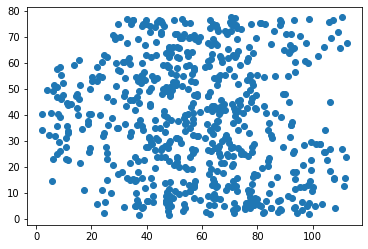

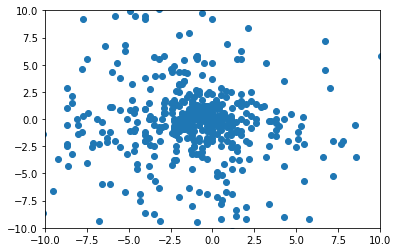

In [22]:
import matplotlib.pyplot as plt
import numpy as np

carries = events[events.type_name == "Carry"]
x = np.array([l[0] for l in carries.location])
y = np.array([l[1] for l in carries.location])
plt.scatter(x,y)
plt.show()
ls = [c["carry"]["end_location"] for c in carries.extra]
ex = np.array([l[0] for l in ls])
ey = np.array([l[1] for l in ls])
a = pd.DataFrame()
a["dx"] = x - ex
a["dy"] = y - ey
plt.scatter(a.dx, a.dy)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()

def movement_polar(actions):
    mov = pd.DataFrame()
    mov["mov_d"] = np.sqrt(actions.dx ** 2 + actions.dy ** 2)
    with np.errstate(divide="ignore", invalid="ignore"):
        mov["mov_angle"] = np.arctan2(actions.dy,actions.dx)
        mov.loc[actions.dy == 0,"mov_angle"] = 0 # fix float errors
    return mov

po = movement_polar(a)
plt.scatter(po.mov_angle,po.mov_d)
#plt.ylim(10,50)
plt.show()

In [23]:
# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created ")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players
    spadlstore["player_games"] = player_games
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]
        
    spadlstore["actiontypes"] = spadl.actiontypes_df()
    spadlstore["results"] = spadl.results_df()
    spadlstore["bodyparts"] = spadl.bodyparts_df()

In [25]:
# Select England vs Belgium game at World Cup
with pd.HDFStore(spadl_h5) as spadlstore:
    games = spadlstore["games"].merge(spadlstore["competitions"])
    game_id = games[(games.competition_name == "Premier League") 
                  & (games.away_team_name == "Chelsea")
                  & (games.home_team_name == "Arsenal")].game_id.values[0]
    actions = spadlstore[f"actions/game_{game_id}"]
    actions = (
        actions.merge(spadlstore["actiontypes"],how="left")
        .merge(spadlstore["results"],how="left")
        .merge(spadlstore["bodyparts"],how="left")
        .merge(spadlstore["players"],how="left")
        .merge(spadlstore["teams"],how="left")
    )

# use nickname if available else use full name
actions["player"] = actions[["player_nickname","player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
actions[:5]

game_id  period_id  time_seconds     timestamp  team_id  player_id  \
0  3749079          1           0.0  00:00:00.906       33      18105   
1  3749079          1           2.0  00:00:02.202       33      20254   
2  3749079          1           2.0  00:00:02.455       33      20254   
3  3749079          1           4.0  00:00:04.331       33      20281   
4  3749079          1           5.0  00:00:05.906       33      20281   

     start_x    start_y      end_x      end_y  ...  result_name  \
0  52.058824  33.655696  54.617647  39.078481  ...      success   
1  54.617647  39.078481  54.617647  39.078481  ...      success   
2  54.617647  39.078481  63.000000  61.372152  ...      success   
3  63.000000  61.372152  63.441176  59.564557  ...      success   
4  63.441176  59.564557  16.058824  39.681013  ...         fail   

   bodypart_name      player_name  player_nickname jersey_number country_id  \
0           foot      Adrian Mutu             None             0        187   
1           foot  Claude Makélélé             None             0         78   
2           foot  Claude Makélélé             None             0         78   
3           foot   Mario Melchiot             None             0        160   
4           foot   Mario Melchiot             None             0        160   

  country_name extra team_name           player  
0      Romania    {}   Chelsea      Adrian Mutu  
1       France    {}   Chelsea  Claude Makélélé  
2       France    {}   Chelsea  Claude Makélélé  
3  Netherlands    {}   Chelsea   Mario Melchiot  
4  Netherlands    {}   Chelsea   Mario Melchiot  

[5 rows x 25 columns]

In [71]:
actions.columns

Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'player_nickname', 'jersey_number',
       'country_id', 'country_name', 'extra', 'team_name', 'player', 'x_zone',
       'next_x_zone', 'y_zone', 'next_y_zone', 'Moments'],
      dtype='object')

In [75]:
#Assigning Proxy associated to x-axis (three Vertical zones)
bins = [0,16.5,35,70,88.5,105]
labels = ["Defensive-Box","Defensive-Third","Middle-Third","Offensive-Third","Offensive-Box"]
actions['x_zone']= pd.cut(actions['start_x'], bins=bins, labels=labels)
actions['next_x1_zone']=actions['x_zone'].shift(-1)
actions['next_x2_zone']=actions['x_zone'].shift(-2)
actions['next_x3_zone']=actions['x_zone'].shift(-3)

In [77]:
Prob=100. * actions.x_zone.value_counts() / len(actions.x_zone)
Prob

Middle-Third       47.936210
Offensive-Third    19.183865
Defensive-Third    13.977486
Offensive-Box      10.600375
Defensive-Box       7.973734
Name: x_zone, dtype: float64

In [78]:
actions.columns

Index(['game_id', 'period_id', 'time_seconds', 'timestamp', 'team_id',
       'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'type_id',
       'result_id', 'bodypart_id', 'action_id', 'type_name', 'result_name',
       'bodypart_name', 'player_name', 'player_nickname', 'jersey_number',
       'country_id', 'country_name', 'extra', 'team_name', 'player', 'x_zone',
       'next_x_zone', 'y_zone', 'next_y_zone', 'Moments', 'next_x1_zone',
       'next_x2_zone', 'next_x3_zone'],
      dtype='object')

In [98]:
chu=actions[actions['Moments']=='Defensive']
group=chu.groupby(['Moments',"team_name", "x_zone"]).size()
Prob=group / len(group)
Prob
#Prob.sort_values(['team_name','Moments'], ascending=[True,False])
chu=actions[actions['Moments']=='Defensive']
group=chu.groupby(["team_name"]).size()
Prob=group / len(group)
Prob

team_name
Arsenal    28.0
Chelsea    27.0
dtype: float64

In [76]:
actions.to_csv(r"C:\Users\Home\Documents\check1.csv")

In [58]:
actions.type_name.unique()

array(['pass', 'dribble', 'clearance', 'take_on', 'keeper_claim', 'foul',
       'freekick_short', 'interception', 'cross', 'shot', 'throw_in',
       'bad_touch', 'tackle', 'shot_freekick', 'freekick_crossed',
       'goalkick', 'keeper_save', 'corner_crossed', 'keeper_punch',
       'corner_short'], dtype=object)

In [66]:
Attack= ['pass', 'dribble', 'take_on','shot', 'cross','bad_touch']
Defensive=['interception','tackle','clearance']    
Restarts=['freekick_short','throw_in','shot_freekick','freekick_crossed','goalkick','corner_crossed', 'corner_short','foul']
Keeper= ['keeper_claim','keeper_save','keeper_punch']

col         = 'type_name'
conditions  = [ actions[col].isin(Attack), actions[col].isin(Defensive), actions[col].isin(Restarts),actions[col].isin(Keeper)]
choices     = [ 'Offensive',"Defensive", 'Restart', 'Keeper' ]
    
actions["Moments"] = np.select(conditions, choices, default=np.nan)

In [74]:
Check=actions[(actions["Moments"]=='Defensive') & (actions['result_name']=='fail')][['type_name','Moments','result_name']]
Check

type_name    Moments result_name
96          tackle  Defensive        fail
121   interception  Defensive        fail
146         tackle  Defensive        fail
263   interception  Defensive        fail
272         tackle  Defensive        fail
359         tackle  Defensive        fail
583         tackle  Defensive        fail
1146        tackle  Defensive        fail
1152        tackle  Defensive        fail
1182        tackle  Defensive        fail
1247  interception  Defensive        fail
1374        tackle  Defensive        fail
1382        tackle  Defensive        fail
1596        tackle  Defensive        fail
1983        tackle  Defensive        fail

In [54]:
import matplotsoccer

shot = 1791
a = actions[shot-4:shot+1].copy()

g = list(games[games.game_id == a.game_id.values[0]].itertuples())[0]
minute = int((a.period_id.values[0]-1)*45 +a.time_seconds.values[0] // 60)
game_info = f"{g.match_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time,axis=1)
labels = a[["nice_time", "type_name", "player", "team_name"]]

matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    zoom=False,
    color="white",
    figsize=5
)
matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team=a.team_name,
    result=a.result_name == "success",
    label=labels,
    labeltitle=["time","actiontype","player","team"],
    color="white",
    zoom=True,
)

2003-10-18 Arsenal 2-1 Chelsea 75'


In [47]:
location=a[["start_x", "start_y", "end_x", "end_y"]]

In [48]:
location

start_x    start_y       end_x      end_y
1787  84.529412  14.718987   84.882353  14.718987
1788  84.882353  14.718987   95.205882  33.397468
1789  96.000000  32.622785   96.000000  32.622785
1790  95.205882  33.827848   96.705882  33.913924
1791  96.705882  33.913924  105.000000  32.364557